The main reference for this tutorial is [Cluster distance inference] (resources/cluster_inference.pdf)

# Global settings

Relative to the root directory, ensure that the R codes (*.R) are "Rcode/" and the data files (*.csv) are in "data/"

In [1]:
rootDir <- "./" # directory containing Rcode/ and data/ directories

In [4]:
setwd(paste(rootDir, "Rcode", sep=""))
conv <- pi/180 
source("general_functions.R")
source("distance_functions.R")
setwd("../")
library(MASS) # for truehist
library(fields) # for image.plot
library(RColorBrewer) # for colorRampPalette
mypalette <- colorRampPalette(brewer.pal(9, "Greys"), space="rgb", interpolate="linear", bias=2.5)
mycols <- mypalette(64)

## Read and check GDR1 data

In [6]:
# parallaxes are in mas, angles in degrees
dat <- read.csv(paste(rootDir, "data/gdr1set03.csv", sep=""), sep=",")
# To prevent hitting numerical limits in the likelihood calculations, retain parallaxes in mas. 
# Thus distances in this notebook are in kpc.
# For testing use a smaller data set
#dat <- dat[1:25,]
# To investigate the impact of larger uncertainties, scale parallax SD:
#dat$parallax_error <- dat$parallax_error*20

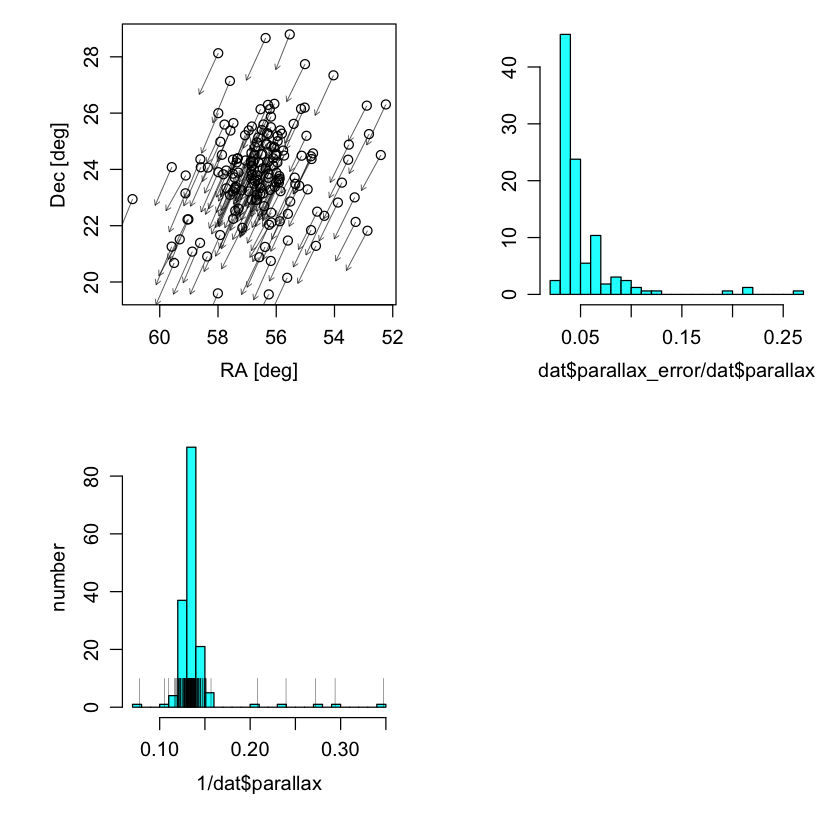

In [7]:
# First inspect the data
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
# Show source positions on sky along with proper motions
plot(dat$ra, dat$dec, xlim=rev(range(dat$ra)), xlab="RA [deg]", ylab="Dec [deg]")
sf <- 0.03 # scale factor for visualizing PM arrows
arrows(dat$ra, dat$dec, dat$ra+sf*dat$pmra, dat$dec+sf*dat$pmdec, length=0.05, lw=0.5)
# Histogram of fractional parallax uncertainties
truehist(dat$parallax_error/dat$parallax, nbins=25)
# Histogram of inverse parallaxes, for orientation.
truehist(1/dat$parallax, nbins=25, prob=FALSE, ylab="number")
segments(x0=1/dat$parallax, y0=0, x1=1/dat$parallax, y1=10, lw=0.3)

## Naive parallax combination

The following methods for estimating the cluster distance from some combination of the parallaxes and their uncertainties are poor. 

First, it is quite wrong to estimate the cluster distance via the mean of the inverse parallaxes (image some parallaxes were negative), and is meaningless when the fractional uncertainties are large. I do it here for comparison (and it's a fair way of getting a feel for the order-of-magnitude that the data imply).

In [19]:
cat("Mean and SD of inverse parallaxes: ", mean(1/dat$parallax), sd(1/dat$parallax), "kpc\n")
# Note that this is an SD in the sense of a spread, not a standard uncertainty in the mean

Mean and SD of inverse parallaxes:  0.1376619 0.02686311 kpc


The next thing we could think about doing is taking the inverse of the mean of parallaxes, and estimating its variance by a first order Taylor expansion. This is a slight improvement, but still not what we should be doing.

In [20]:
Nstar <- nrow(dat)
mpar  <- mean(dat$parallax)
rNaive1 <- 1/mpar
rNaive1SD <- (1/Nstar)*sqrt(sum(dat$parallax_error^2)) / mpar^2
cat("Inverse of mean parallaxes: ", rNaive1, "+/-", rNaive1SD, "kpc\n")
# This gives an estimate of the distance to the cluster, together with the standard deviation in this mean.
cat("SD of inverse mean parallax in the sense of a spread:", sd(dat$parallax_error)/mpar^2, "kpc\n")

Inverse of mean parallaxes:  0.1347596 +/- 0.0005589137 kpc
SD of inverse mean parallax in the sense of a spread: 0.002887234 kpc


We could go one step further and take a (variance) weighted mean. Specifically, take the inverse of the variance weighted mean of the parallaxes and estimate the variance of this again by a first order Taylor expansion.

In [21]:
wfac <- sum(1/dat$parallax_error^2)
wmpar <- sum(dat$parallax/dat$parallax_error^2)/wfac
rNaive2 <- 1/wmpar
rNaive2SD <- 1/(wmpar^2 * sqrt(wfac))
cat("Inverse of weighted mean of parallaxes: ", rNaive2, "+/-", rNaive2SD, "kpc\n")

Inverse of weighted mean of parallaxes:  0.1337066 +/- 0.000428167 kpc


## Estimate distance to cluster (no correlations or cluster spread)

Rather than mucking about with inverting and averaging the parallaxes, we should think about what we want to achieve. We want to infer the distance, $r$, to the cluster given a set of parallaxes $\{\varpi\}$ and corresponding parallax uncertainties $\{\sigma_{\varpi}\}$ of (some of) its members. Let's assume, for now, that the cluster is very small compared to its distance from us, such that we can consider the true distance to all the stars to be the same ("no cluster spread"), and equal to the distance of cluster, $r$. We proceed as for the single star case, but now using a multivariate likelihood. For $N$ stars this is an $N$-dimensional Gaussian. If we assume (for now) that the parallaxes are independent ("no correlations"), then this is just a product of $N$ 1-dimensional Gaussians. The posterior is

\begin{alignat}{2}
P(r|\{\varpi\}, \{\sigma_{\varpi}\}, L) 
&\propto \ P(r|L) \ P(\{\varpi\} | r, \{\sigma_{\varpi}\}) \\
&\propto \ P(r|L) \ \prod_i P(\varpi_i | r, \sigma_{\varpi_i})
\end{alignat}


Let's compute and plot the posterior, using the exponentially decreasing space density prior with length scale rlen.

In [22]:
# Set the length scale of the prior
rlen <- 1e3
# The unnormalized posterior is computed by the function ud.distpost3multi,
# which by default assumes no correlations in the likelihood.
# As it involves a product of lots of small numbers, the posterior density can 
# drop below the numerical precision, so check this here before trying to plot.
r <- seq(from=0.130, to=0.140, length.out=1e3)
#r <- seq(from=0.100, to=0.200, length.out=1e3) # to use with x20 uncertainties
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, rlen=rlen)
dense[sample(length(r),10)] # print 10 random samples
range(dense)

[1] 9.227074e-258 1.637853e-237 1.499894e-278 1.073935e-249 4.854019e-258
 [6] 2.299190e-265 6.894351e-239 8.096087e-274 2.133397e-247 2.494521e-253

[1] 5.722146e-280 3.220841e-237

Posterior mean, SD for rc = 0.1337135 0.0004282285 kpc


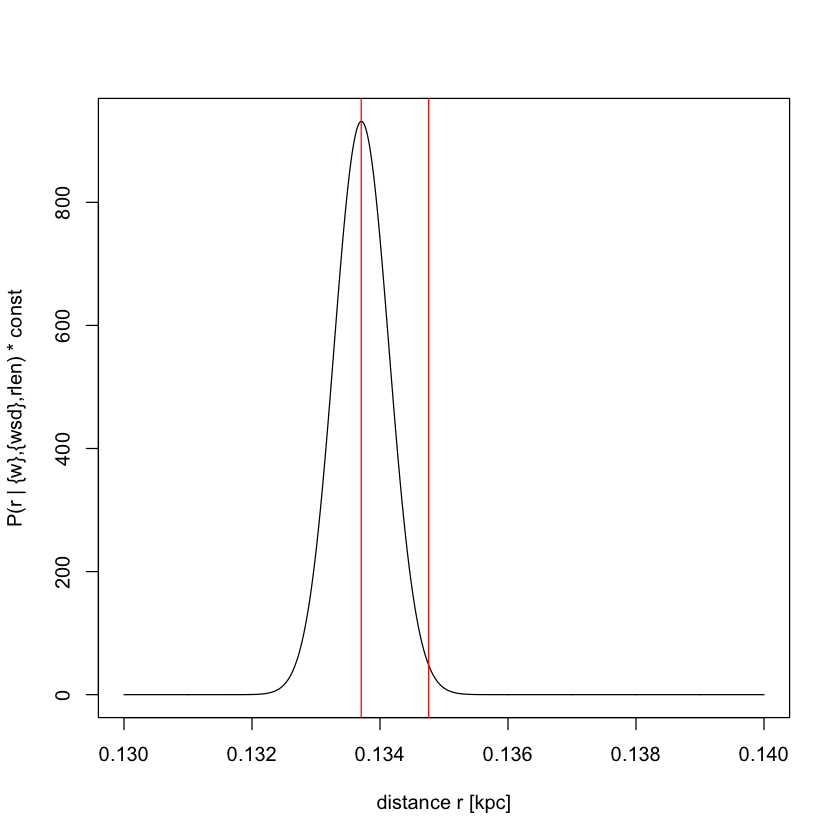

In [23]:
# Estimate the normalization constant, mean, and standard deviation of the posterior
# directly from the tabulation (using pdfmom)
mom <- pdfmom(dense, r)
cat("Posterior mean, SD for rc =", mom$mean, mom$sd, "kpc\n")
plot(r, dense/mom$Z, type="l", xlab="distance r [kpc]", ylab="P(r | {w},{wsd},rlen) * const")
abline(v=c(rNaive1, rNaive2), col="red")
# Note that in this case the mode is very close to rNaive2, because the data are highly 
# informative compared to the prior, so the maximum of the posterior is very 
# close to the maximum of the likelihood.

## Invent simple model for spatial parallax correlations

I now allow for correlations between the parallaxes. Given a set of $N$ parallax measurements, their correlations are determined by the $N \times N$ covariance matrix $C$. The likelihood for the $N$ measurements is no longer a product of $N$ one-dimensional Gaussian functions, but is rather an $N$-dimensional Gaussian

$
P({\boldsymbol \varpi} | {\mathbf r}, C) = \frac{1}{(2\pi)^{N/2}|C|^{1/2}}\exp\left[-\frac{1}{2}\left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)^\mathsf{T} C^{-1} \left({\boldsymbol \varpi} - \frac{1}{{\mathbf r}}\right)\right]
$

where

$
\frac{1}{{\mathbf r}} = \left(\frac{1}{r_1}, \frac{1}{r_2}, \ldots \right) .
$

To illustrate this approach I invent a model (unrelated to Gaia!) which specifies that the correlation between any two parallax measurements, $\varpi_1$ and $\varpi_2$, is a function of the angular separation, $\theta$, of the two sources on the sky

$
\rho(\varpi_1, \varpi_2) = a\exp(-\theta/\theta_{\rm len})
$


where $\theta_{\rm len}>0$ is some fixed angular scale and $0\leq a \leq 1$ gives the amplitude of the correlation at zero separation. The elements of the covariance matrix $C$ are 

$
C_{i,j} = \rho(\varpi_i, \varpi_j)\sigma_{\varpi_i}\sigma_{\varpi_j}.
$

Provided the two sources are not widely separated and not near the poles, we can approximate their angular separation as

$
\theta = \left( [(\alpha_1\!-\!\alpha_2)\cos(0.5(\delta_1\!+\!\delta_2))]^2 + (\delta_1\!-\!\delta_2)^2  \right)^{1/2}
$

where $(\alpha, \delta)$ are the RA and declination of a source.

In the code that follows, the function parcor computes $\rho$, and parcovmat computes $C$.

In [ ]:
# Function parcor computes correlations between parallaxes for sources according to
# amp*exp(-sep/len), where sep is the angular separation on the sky of two sources,
# 0<=amp<=1, and len>=0 is the length scale.
parcor(dat$ra[1], dat$dec[1], dat$ra[2], dat$dec[2], amp=0.5, len=0.5)
# Function parcovmat compute parallax covariance matrix for given sources plus parameters for parcor
(mat <- parcovmat(dat=dat[1:3,], amp=0.5, len=0.5))
# d.likemulti computes the density of an N-dimensional likelihood (i.e. for N sources) with
# specified covariance matrix (parcovmat). For independent parallaxes, use parcovmat=NULL.
d.likemulti(w=dat$parallax[1:3], r=0.12, wsd=dat$parallax_error[1:3], parcovmat=mat)

## Naive parallax combination with correlations

This would just be maximum likelihood, which is equal to maximum posterior with a uniform (non-truncated) prior. 
So we'll just skip this and get to the more general posterior solution.

## Distance estimation with correlations

In [31]:
# ud.distpost3multi accommodates parallax covariances when its argument parcovmat!=NULL
rlen <- 1 # kpc!
# test the function: the following two numbers should be identical
ud.distpost3multi(r=0.120, w=dat$parallax[1:4], wsd=dat$parallax_error[1:4], rlen=rlen)
ud.distpost3multi(r=0.120, w=dat$parallax[1:4], wsd=dat$parallax_error[1:4], 
                  parcovmat=diag(dat$parallax_error[1:4]^2), rlen=rlen)

[1] 6.465014e-08

[1] 6.465014e-08

In [32]:
# compute covariance matrix 
mat <- parcovmat(dat=dat, amp=0.5, len=0.5)

Posterior mean, SD for r = 0.1341392 0.0007135305 kpc
Posterior mean, SD for r = 0.1337133 0.0004282268 kpc


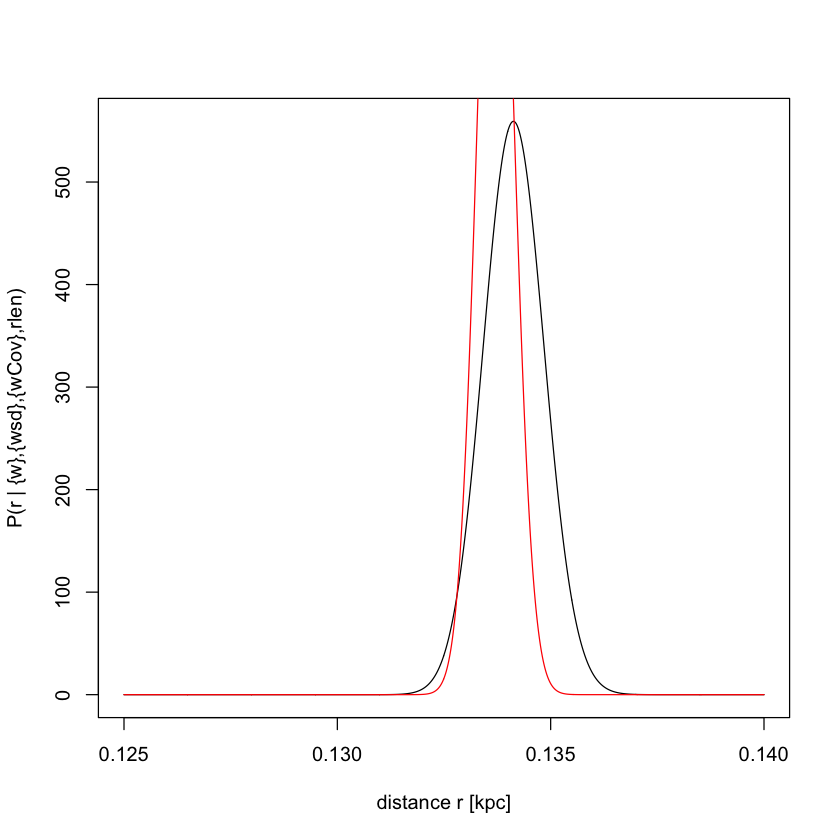

In [34]:
# compute posterior (scaled to have maximum=1) on a grid and plot
r <- seq(from=0.125, to=0.140, length.out=1e3)
#r <- seq(from=0.050, to=0.250, length.out=1e3) # with x20 uncertainties
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, parcovmat=mat, rlen=rlen)
mom <- pdfmom(dense, r)
cat("Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
plot(r, dense/mom$Z, type="l", xlab="distance r [kpc]", ylab="P(r | {w},{wsd},{wCov},rlen)")
# overplot result (obtained above) without correlations
dense <- ud.distpost3multi(r=r, w=dat$parallax, wsd=dat$parallax_error, rlen=rlen)
mom <- pdfmom(dense, r)
cat("Posterior mean, SD for r =", mom$mean, mom$sd, "kpc\n")
lines(r, dense/mom$Z, col="red")

## Infer cluster distance and size (no correlations)

We now want posterior P*(rc,sc|{w},{wsd}), where rc and sc are cluster distance and size respectively. The cluster center in (RA, Dec) is assumed known. I nominally assume the true stellar distances are drawn from a 3D isotropic Gaussian of mean rc and standard deviation sc. In general the likelihood is a marginalization
over the N unknown distances, i.e. an N-dimensional integral. Here I neglect any correlations between the parallax measurements to reduce this to a product of N one-dimensional integrals. I then proceed in three different ways, which corresponds to three different simplifications to this likelihood. 
1. Nelgect the angular size of the cluster. I can therefore assume that the true distances of the stars from the cluster center (z) are along the l.o.s, and thus drawn from a 1D Gaussian with mean 0 and stdev sc. To simplify the integral (which is otherwise intractable), I further perform a binomial approximation of (w-1/r) with r=r_c+x. The integral is can then be expressed in terms of an error function, which is fast. This is done by d.likecluster1.
2. As 1, but now without the binomial approximation, and using numerical integration (Gaussian quadrature) instead. (Motivation: the binomial approxiation seems to be poor.) This is done by d.listcluster2, with argument costheta=NULL.
3. Retain the full 3D model. For this we must specify the angular separations of the stars from the cluster centre, costheta. The integrals are done numerically (Gaussian quadrature). Sometimes the integrals don't converge (presumably due to limitations of the R function "integrate"), so for those specific cases (given star and rc,sc values) I revert to case 2 (for which there is no justification other than that's robust). It currently doesn't work too well. This is also done by d.likecluster2

I use separable priors on cluster distance and cluster size. For the former I use the exponential decreasing space density prior. I compute the posterior on a regular 2D grid of (rc,sc).

### The cluster size prior (and set parameter of distance prior)

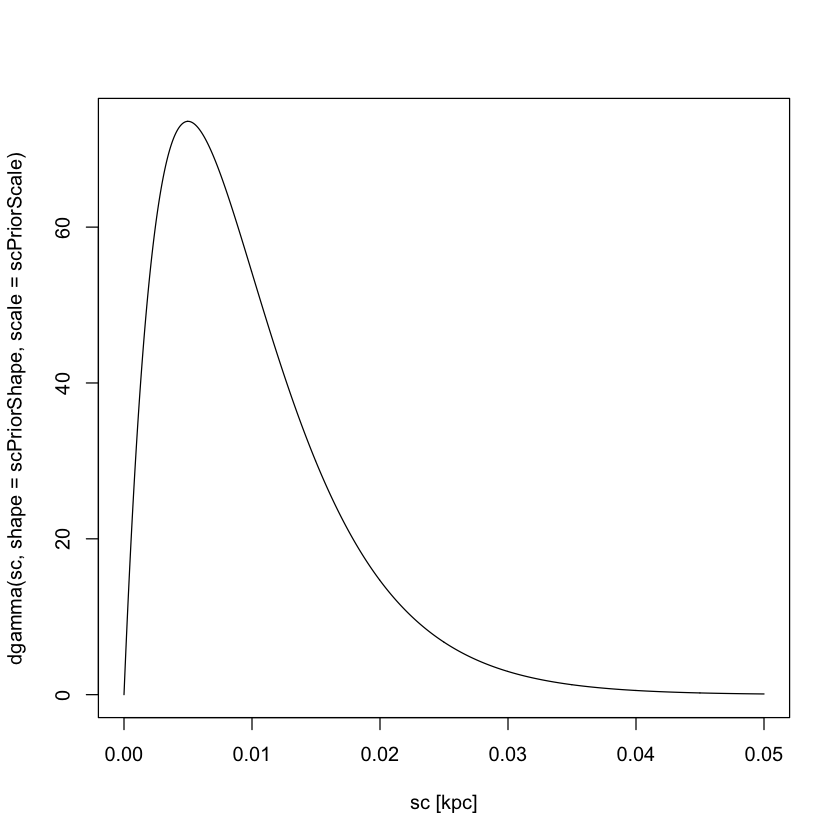

In [35]:
# I use the following gamma distribution prior
sc <- seq(from=0, to=0.050, length.out=1e3)
scPriorShape <- 2
scPriorScale <- 0.005
plot(sc, dgamma(sc, shape=scPriorShape, scale=scPriorScale), type="l", xlab="sc [kpc]")
# Set parameter of distance prior
rlen <- 1 # kpc!

### Use this block to generate simulated data in order to test likelihood 1 & 2 (overwrites dat!)

In [39]:
# True cluster is 1D along the l.o.s, so strictly theta=0 for all of them.
# Thus cannot expect results with Likelihood 3 below to be good (as that assumes a spherical cluster).
set.seed(12345)
rcTrue <- 0.120
scTrue <- 0.01
Nstar <-  25
rTrue <- rnorm(n=Nstar,mean=rcTrue,sd=scTrue)
wsd <- rep.int(x=0.3,times=Nstar) 
w <- rnorm(n=Nstar,mean=1/rTrue,sd=wsd) # generates one random variable for each row of cbind(w,wsd)
dat <- data.frame(parallax=w, parallax_error=wsd)
dat[1:10,]

parallax,parallax_error
9.583901,0.3
9.038532,0.3
9.481968,0.3
8.606297,0.3
8.499794,0.3
8.281047,0.3
7.552662,0.3
9.225395,0.3
7.711249,0.3
9.866970,0.3


### Likelihood 2 (1D approximation, numerical integrations)

In [36]:
# Evaluate 2D posterior on the following grid.
# This takes about 2.5 minutes on my laptop using gdr1set03.csv (164 stars), 
# so first test it using 10-20 simulated stars (see code for this above)
rc <- seq(from=0.120, to=0.140, length.out=100)
sc <- seq(from=0.0001, to=0.030, length.out=100)
dense <- matrix(0, nrow=length(rc), ncol=length(sc))
cat("Of", length(sc), "outer loop steps, no. remaining:\n")
for(j in 1:length(sc)) {
  cat(j," ")
  for(i in 1:length(rc)) {
    dense[i,j] <- d.likecluster2(w=dat$parallax, wsd=dat$parallax_error, rc=rc[i], sc=sc[j]) *
      d.distprior3(r=rc[i], rlen=rlen)*dgamma(x=sc[j], shape=scPriorShape, scale=scPriorScale)   
  }
}
cat("\n")

Of 100 outer loop steps, no. remaining:
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  


[1] 0.00000e+00 1.22083e-99

Posterior mean, SD for sc = 0.01316349 0.0009870501 kpc
Posterior mean, SD for rc = 0.1356696 0.001145217 kpc


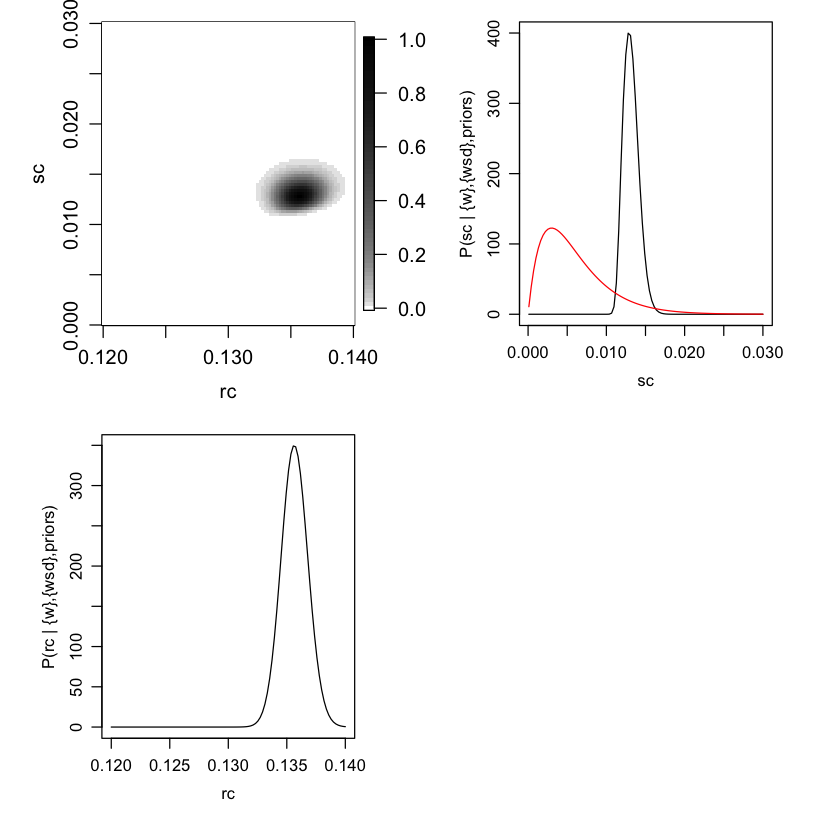

In [80]:
# Plot 2D posterior as well as the two marginal PDFs (achieved simply by summing grid, as it's regular)
range(dense)
dense <- dense/max(dense)
par(mfrow=c(2,2), mar=c(5,5,0.5,1), oma=c(0.1,0.1,0.5,0.1), mgp=c(2.2,0.8,0), cex=1.0) 
image.plot(z=dense, x=rc, y=sc, nlevel=1024, col=mycols)
scDense <- apply(dense, 2, sum)
mom <- pdfmom(scDense, sc)
cat("Posterior mean, SD for sc =", mom$mean, mom$sd, "kpc\n")
plot(sc, scDense/mom$Z, type="l", ylab="P(sc | {w},{wsd},priors)")
lines(sc, dgamma(sc, shape=2, scale=0.003), col="red") # overplot prior on sc
rcDense <- apply(dense, 1, sum)
mom <- pdfmom(rcDense, rc)
cat("Posterior mean, SD for rc =", mom$mean, mom$sd, "kpc\n")
plot(rc, rcDense/mom$Z, type="l", ylab="P(rc | {w},{wsd},priors)")
# compare result with parallaxes (!) derived in GDR1 overview and cluster papers